# Query para Churn Semestral já Retirando os Anos de 2004 e 2005 (anomalias)

✅ Sucesso! Os dados foram carregados em 'df_churn_semestral'.
------------------------------
  periodo_semestral  clientes_inicio_semestre  total_churn_no_semestre  \
0           2015-S1                      4314                      496   
1           2015-S2                      4427                      452   
2           2016-S1                      4679                      480   
3           2016-S2                      4814                      468   
4           2017-S1                      4562                      388   
5           2017-S2                      4367                      354   
6           2018-S1                      4244                      358   
7           2018-S2                      4194                      357   
8           2019-S1                      4189                      311   
9           2019-S2                      4262                      313   

   churn_rate_semestral_percentual   analise_saude  
0                            11.50  CRÍ

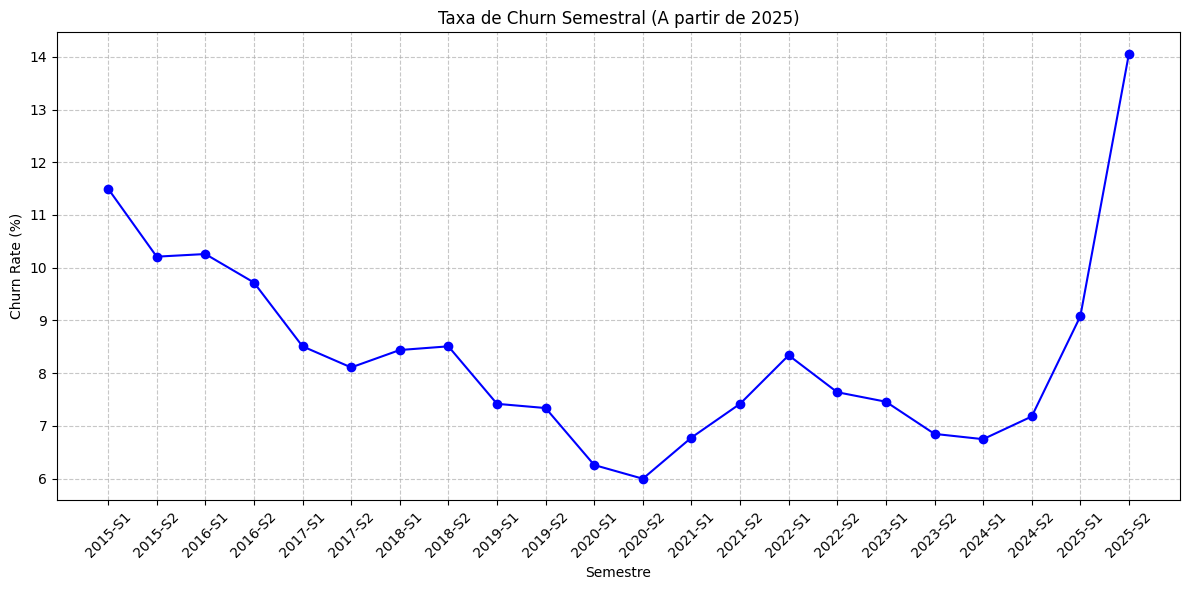

In [6]:
import os
import pandas as pd
import urllib.parse
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

# 1. Carregar variáveis de ambiente
load_dotenv()

# 2. Configuração das credenciais com tratamento de caracteres especiais
user     = os.getenv("PROD_POSTGRES_USERNAME")
password = urllib.parse.quote_plus(os.getenv("PROD_POSTGRES_PASSWORD"))
host     = os.getenv("PROD_POSTGRES_HOST")
database = os.getenv("PROD_POSTGRES_DATABASE")
port     = os.getenv("POST_PORT", "5432")

conn_url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(conn_url)

# 3. Definição da Query SQL de Churn Semestral (Início em 2006)
sql_query = """
with base_contratos as (
    select
        distinct
        c.nr_central_sigma,
        ccc.codigo_contrato,
        ccc.data_pedido as data_inicio,
        ccc.data_rescisao,
        (
            select mcc.situacao
            from movimento_contratos_cli mcc
            where mcc.codigo_contrato = ccc.codigo_contrato
              and mcc.situacao <> 7
            order by mcc.data_conclusao desc
            limit 1
        ) as situacao_movimento
    from clientes c
    inner join cab_contratos_cli ccc on ccc.codigo_cliente = c.codigo_cliente
),

clientes_com_contrato_ativo as (
    select distinct nr_central_sigma
    from base_contratos
    where data_rescisao is null
),

churn_por_cliente as (
    select
        bc.nr_central_sigma,
        MAX(bc.data_rescisao) as data_churn
    from base_contratos bc
    where bc.data_rescisao is not null
      and bc.nr_central_sigma not in (select nr_central_sigma from clientes_com_contrato_ativo)
    group by bc.nr_central_sigma
),

data_minima as (
    -- Alterado para iniciar em 2015 e definir o teto em 2025
    select 
        '2015-01-01'::date as inicio_historico,
        '2025-12-31'::date as fim_historico
),

churn_semestral as (
    select
        date_trunc('year', ch.data_churn) + (interval '6 months' * floor((extract(month from ch.data_churn) - 1) / 6)) as semestre_churn,
        COUNT(distinct ch.nr_central_sigma) as clientes_churn
    from churn_por_cliente ch
    group by 1
),

clientes_ativos_inicio_semestre as (
    select
        ss.semestre,
        COUNT(distinct bc.nr_central_sigma) as total_clientes_inicio
    from (
        select generate_series(
            (select inicio_historico from data_minima),
            (select fim_historico from data_minima),
            '6 months'
        )::date as semestre
    ) ss
    cross join base_contratos bc
    where bc.data_inicio < ss.semestre
      and (bc.data_rescisao is null or bc.data_rescisao >= ss.semestre)
    group by ss.semestre
)

select
    concat(
        extract(year from cas.semestre), 
        case when extract(month from cas.semestre) <= 6 then '-S1' else '-S2' end
    ) as periodo_semestral,
    cas.total_clientes_inicio as clientes_inicio_semestre,
    coalesce(cs.clientes_churn, 0) as total_churn_no_semestre,
    case
        when cas.total_clientes_inicio = 0 then 0
        else ROUND((coalesce(cs.clientes_churn, 0)::numeric / cas.total_clientes_inicio::numeric) * 100, 2)
    end as churn_rate_semestral_percentual,
    case 
        when (coalesce(cs.clientes_churn, 0)::numeric / nullif(cas.total_clientes_inicio,0)::numeric) * 100 > 10 then 'CRÍTICO (>12%)'
        when (coalesce(cs.clientes_churn, 0)::numeric / nullif(cas.total_clientes_inicio,0)::numeric) * 100 > 7.5 then 'ALERTA'
        else 'DENTRO DA META'
    end as analise_saude
from clientes_ativos_inicio_semestre cas
left join churn_semestral cs on cas.semestre = cs.semestre_churn
where cas.total_clientes_inicio > 0
  and cas.semestre <= (select fim_historico from data_minima)
order by cas.semestre;
"""

# 4. Execução da consulta
try:
    with engine.connect() as conn:
        df_churn_semestral = pd.read_sql(text(sql_query), conn)

    print("✅ Sucesso! Os dados foram carregados em 'df_churn_semestral'.")
    print("-" * 30)
    print(df_churn_semestral.head(10)) # Exibe os primeiros 10 semestres 
    print("-" * 30)

    # 5. Visualização Básica
    plt.figure(figsize=(12, 6))
    plt.plot(df_churn_semestral['periodo_semestral'], df_churn_semestral['churn_rate_semestral_percentual'], marker='o', linestyle='-', color='b')
    plt.title('Taxa de Churn Semestral (A partir de 2025)')
    plt.xlabel('Semestre')
    plt.ylabel('Churn Rate (%)')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Erro ao executar consulta: {e}")

In [7]:
df_churn_semestral

,periodo_semestral,clientes_inicio_semestre,total_churn_no_semestre,churn_rate_semestral_percentual,analise_saude
0,2015-S1,4314,496,11.50,CRÍTICO (>12%)
1,2015-S2,4427,452,10.21,CRÍTICO (>12%)
2,2016-S1,4679,480,10.26,CRÍTICO (>12%)
3,2016-S2,4814,468,9.72,ALERTA
4,2017-S1,4562,388,8.51,ALERTA
5,2017-S2,4367,354,8.11,ALERTA
6,2018-S1,4244,358,8.44,ALERTA
7,2018-S2,4194,357,8.51,ALERTA
8,2019-S1,4189,311,7.42,DENTRO DA META
9,2019-S2,4262,313,7.34,DENTRO DA META


# Iniciando Analise Descritiva da Base Semestral

### Estudo da Volatilidade e Tendência Central Semestral

In [8]:
# Média e Mediana 
media_semestral = df_churn_semestral['churn_rate_semestral_percentual'].mean()
mediana_semestral = df_churn_semestral['churn_rate_semestral_percentual'].median()
print(mediana_semestral)
print(media_semestral)

7.875
8.356363636363637


In [10]:
# 1. Cálculo de métricas estatísticas detalhadas
media_semestral = df_churn_semestral['churn_rate_semestral_percentual'].mean()
mediana_semestral = df_churn_semestral['churn_rate_semestral_percentual'].median()
desvio_padrao = df_churn_semestral['churn_rate_semestral_percentual'].std()

print(f"Estatísticas de Churn (2006 - Presente):")
print(f"Média:   {media_semestral:.2f}%")
print(f"Mediana: {mediana_semestral:.2f}%")
print(f"Desvio Padrão: {desvio_padrao:.2f}% (Quanto menor, mais constante é o churn)")

# 2. Identificar os 3 piores semestres (Maiores Churns)
piores_semestres = df_churn_semestral.nlargest(3, 'churn_rate_semestral_percentual')
print("\n🚨 Top 3 Semestres com maior Churn:")
print(piores_semestres[['periodo_semestral', 'churn_rate_semestral_percentual']])

# 3. Criar uma coluna de variação (comparando com o semestre anterior)
df_churn_semestral['variacao_percentual'] = df_churn_semestral['churn_rate_semestral_percentual'].diff()

print("\n📈 Últimos 5 semestres analisados:")
print(df_churn_semestral[['periodo_semestral', 'churn_rate_semestral_percentual', 'analise_saude']].tail())

Estatísticas de Churn (2006 - Presente):
Média:   8.36%
Mediana: 7.88%
Desvio Padrão: 1.89% (Quanto menor, mais constante é o churn)

🚨 Top 3 Semestres com maior Churn:
   periodo_semestral  churn_rate_semestral_percentual
21           2025-S2                            14.06
0            2015-S1                            11.50
2            2016-S1                            10.26

📈 Últimos 5 semestres analisados:
   periodo_semestral  churn_rate_semestral_percentual   analise_saude
17           2023-S2                             6.85  DENTRO DA META
18           2024-S1                             6.75  DENTRO DA META
19           2024-S2                             7.18  DENTRO DA META
20           2025-S1                             9.08          ALERTA
21           2025-S2                            14.06  CRÍTICO (>12%)
